<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



<font color='red'>**Задание:**</font> заполните код в этой тетрадке и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../../data/kagle'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
import glob as gl
import datetime
import re

In [67]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    files = gl.glob(path_to_csv_files + "/*.csv")
    data = []
    user_id = 1
    y = []
    session_timespan = []
    uniq_sites = []
    start_hour = []
    day_of_week = []
    with open( site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)
    for f in files:
        match = re.search(r'user[0]*([1-9][0-9]*)', f)
        user_id = int(match.group(1))
        #print(user_id)
        df = pd.read_csv(f)
        df.timestamp = df.timestamp.apply(pd.to_datetime)
   
        session_num = df.shape[0]// session_length + 1
        left_edge = 0
        right_edge = session_length if session_length < df.shape[0] else df.shape[0]
        time_stamps = df.timestamp.apply(lambda ts: ts.timestamp()).values.reshape((df.shape[0],1))
        
        while(left_edge < df.shape[0]):
            temp_site = np.asarray(site_id_list[left_edge: right_edge]) if (right_edge - left_edge) == session_length else \
                        np.append(site_id_list[left_edge: right_edge], np.zeros(session_length - (right_edge - left_edge)))
            temp_time_diff = time_stamps[left_edge + 1:right_edge,0] - time_stamps[left_edge:right_edge -1,0]
            #print(temp_time_diff)
            temp_time_diff = temp_time_diff.astype(int) \
                            if (right_edge - left_edge) == session_length else \
                   np.append(temp_time_diff.astype(int), np.zeros(session_length - (right_edge - left_edge)))
            data.append(np.append(temp_site,temp_time_diff ))
            
            session_timespan.append(time_stamps[left_edge: right_edge].max(axis = 0) - time_stamps[left_edge: right_edge].min(axis = 0) )
            uniq_sites.append(np.unique(temp_site).shape[0])
            min_timestamp = datetime.datetime.fromtimestamp(int(time_stamps[left_edge,0]))
            start_hour.append(min_timestamp.hour)
            day_of_week.append(min_timestamp.weekday())
            y.append(user_id) 
            left_edge += window_size
            right_edge = (right_edge + window_size) if (right_edge + window_size) < df.shape[0] else df.shape[0]
        
        #user_id +=1 
    
    X = np.c_[np.asarray(data),np.asarray(session_timespan), np.asarray(uniq_sites), np.asarray(start_hour) \
               , np.asarray(day_of_week), np.asarray(y)]
    train_df = pd.DataFrame(data = X, columns = feature_names)
    
    train_df = train_df.astype(int)
 
    return train_df

**Проверим функцию на игрушечном примере.**

In [65]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

1
2
3


In [57]:
st = r'../../data/kagle\3users\user0031.csv'
match = re.search(r'user[0]*([1-9][0-9]*)', st)
match.group(1)

'31'

In [47]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,3,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,4,9,4,1
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,1
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,4,12,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [66]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

31
33
39
50
100
127
128
207
237
241
Wall time: 34.9 s


In [58]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [50]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 6min 9s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [51]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour','day_of_week'] ]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour','day_of_week'] ]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [13]:
new_features_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [14]:
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [15]:
new_features_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [16]:
new_features_150users['#unique_sites'].median() 

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [68]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [69]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

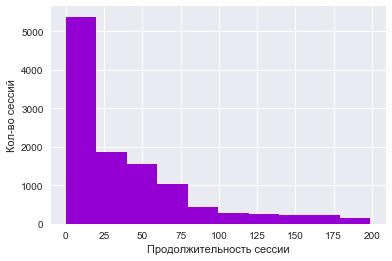

In [19]:
train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan'].hist(facecolor='darkviolet')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Кол-во сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

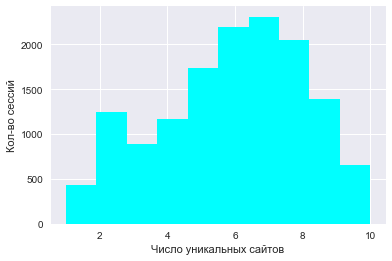

In [20]:
train_data_10users['#unique_sites'].hist(facecolor='aqua')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Кол-во сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [74]:
print(pd.groupby(train_data_10users, 'target').groups['Ashley'])

Int64Index([1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791,
            ...
            3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985],
           dtype='int64', length=2204)


0
Ashley
1
Avril
2
Bill
3
Bob
4
Dick
5
Ed
6
John
7
Lindsey
8
Mary-Kate
9
Naomi


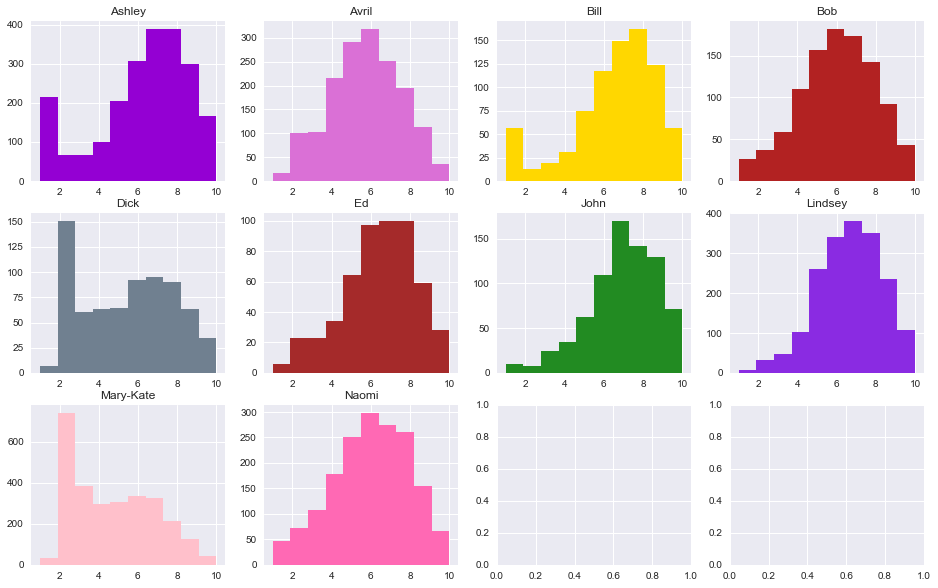

In [88]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx //4, idx%4 ].hist(sub_df['#unique_sites'], color = color_dic[user] )
    axes[idx//4, idx%4].set_title(user)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

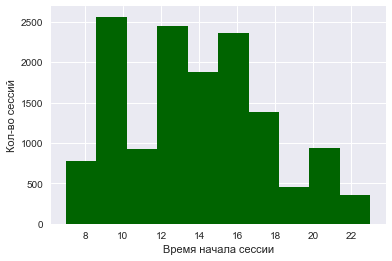

In [89]:
train_data_10users['start_hour'].hist(facecolor='darkgreen')
plt.xlabel('Время начала сессии')
plt.ylabel('Кол-во сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

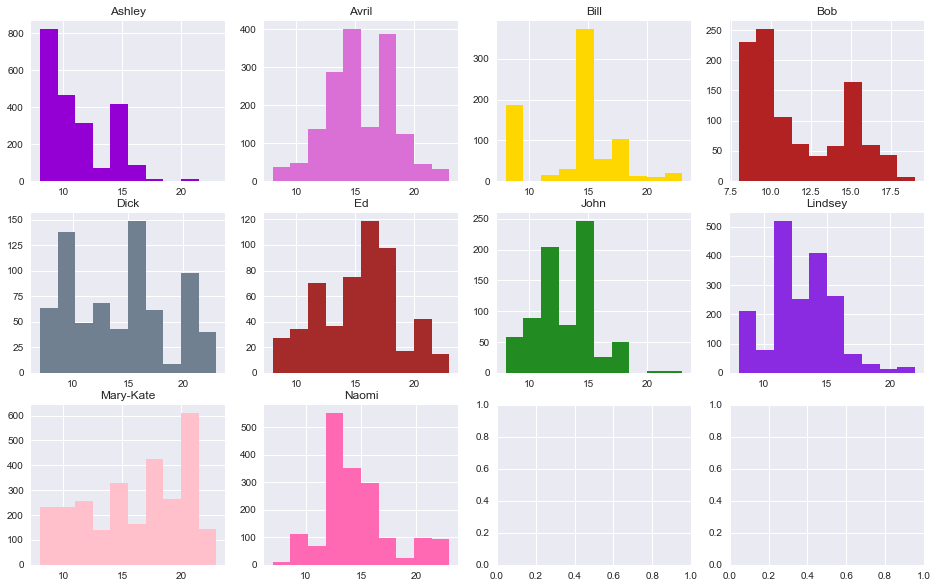

In [91]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx //4, idx%4 ].hist(sub_df['start_hour'], color = color_dic[user] )
    axes[idx//4, idx%4].set_title(user)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

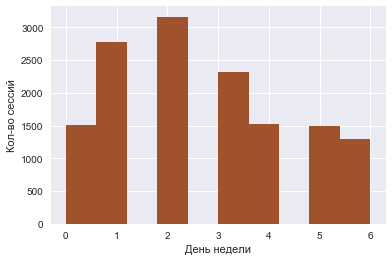

In [92]:
train_data_10users['day_of_week'].hist(facecolor='sienna')
plt.xlabel('День недели')
plt.ylabel('Кол-во сессий')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

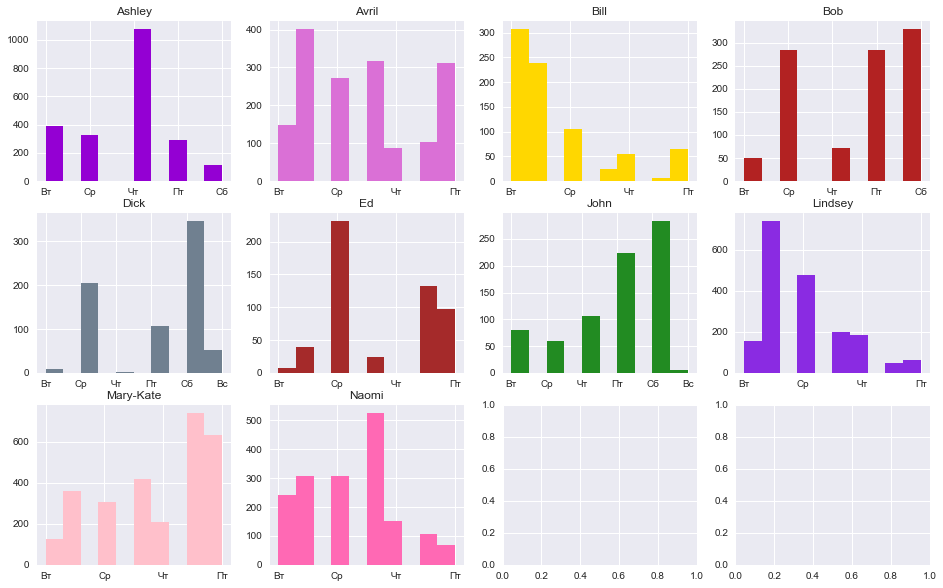

In [94]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx //4, idx%4 ].hist(sub_df['day_of_week'], color = color_dic[user] )
    axes[idx//4, idx%4].set_title(user)
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [97]:
with open( os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
        site_dict = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [108]:
def take_freq(elem):
    temp = elem[1]
    return temp[1]
sort_dict = sorted(site_dict.items(), key=take_freq, reverse = True)
sort_dict

[('s.youtube.com', (210, 8300)),
 ('www.google.fr', (51, 7813)),
 ('www.google.com', (4, 5441)),
 ('mail.google.com', (183, 4158)),
 ('www.facebook.com', (15, 4141)),
 ('apis.google.com', (52, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (214, 3094)),
 ('plus.google.com', (187, 2630)),
 ('accounts.google.com', (184, 2089)),
 ('r2---sn-gxo5uxg-jqbe.googlevideo.com', (699, 1939)),
 ('fr-mg42.mail.yahoo.com', (622, 1868)),
 ('www.youtube.com', (207, 1804)),
 ('r4---sn-gxo5uxg-jqbe.googlevideo.com', (208, 1702)),
 ('clients1.google.com', (568, 1493)),
 ('download.jboss.org', (1796, 1441)),
 ('s-static.ak.facebook.com', (66, 1388)),
 ('static.ak.facebook.com', (63, 1265)),
 ('i1.ytimg.com', (205, 1232)),
 ('twitter.com', (72, 1204)),
 ('accounts.youtube.com', (185, 1057)),
 ('platform.twitter.com', (70, 1041)),
 ('clients6.google.com', (191, 1039)),
 ('safebrowsing-cache.google.com', (576, 1039)),
 ('translate.google.fr', (1026, 1

In [114]:
top10_freqs = [x[1][1] for x in sort_dict][0:10]
top10_site = [x[0] for x in sort_dict][0:10]
#site_dict.values

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

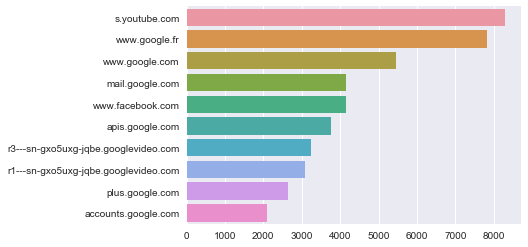

In [115]:
sns.barplot(top10_freqs,top10_site)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

На следующей неделе мы наконец приступим к обучению моделей классификации. 